# TreeBoxes - Baseline DeepForest Model

In this notebook, we illustrate the structure of the datasets and performance of the baseline box model against the official training split.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import torch
import matplotlib

if os.path.basename(os.getcwd()) == 'examples':
    sys.path.append("../")
    
import milliontrees

We will use the DeepForest bounding box model available at https://deepforest.readthedocs.io/en/v1.4.1/user_guide/02_prebuilt.html#tree-crown-detection-model

In [3]:
from deepforest import main
m = main.deepforest()
m.load_model("weecology/deepforest-tree")

/Users/benweinstein/miniconda3/envs/MillionTrees/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Reading config file: /Users/benweinstein/miniconda3/envs/MillionTrees/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Reading config file: /Users/benweinstein/miniconda3/envs/MillionTrees/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


     xmin   ymin   xmax   ymax label     score    image_path  \
0   330.0  342.0  373.0  391.0  Tree  0.802979  OSBS_029.png   
1   216.0  206.0  248.0  242.0  Tree  0.778803  OSBS_029.png   
2   325.0   44.0  363.0   82.0  Tree  0.751573  OSBS_029.png   
3   261.0  238.0  296.0  276.0  Tree  0.748605  OSBS_029.png   
4   173.0    0.0  229.0   33.0  Tree  0.738210  OSBS_029.png   
5   258.0  198.0  291.0  230.0  Tree  0.716250  OSBS_029.png   
6    97.0  305.0  152.0  363.0  Tree  0.711664  OSBS_029.png   
7    52.0   72.0   85.0  108.0  Tree  0.698782  OSBS_029.png   
8   292.0  368.0  332.0  400.0  Tree  0.688486  OSBS_029.png   
9   249.0   51.0  277.0   81.0  Tree  0.688165  OSBS_029.png   
10  317.0  181.0  345.0  210.0  Tree  0.686540  OSBS_029.png   
11   18.0  346.0   57.0  388.0  Tree  0.668805  OSBS_029.png   
12  272.0  330.0  305.0  367.0  Tree  0.666738  OSBS_029.png   
13  277.0    0.0  311.0   31.0  Tree  0.654231  OSBS_029.png   
14  195.0  339.0  227.0  371.0  Tree  0.

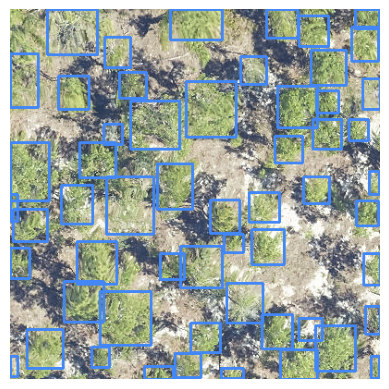

In [4]:
from deepforest import get_data
from deepforest.visualize import plot_results
from deepforest.utilities import read_file

boxes = m.predict_image(path=get_data("OSBS_029.png"))

print(boxes)
plot_results(boxes)

In [6]:
# Load the box dataset
from milliontrees import get_dataset
from milliontrees.common.data_loaders import get_eval_loader

box_dataset = get_dataset("TreeBoxes", download=True)
box_test_data = box_dataset.get_subset("test")

6697115648Byte [03:37, 30843377.09Byte/s]                       


Extracting data/TreeBoxes_v0.1/archive.zip to data/TreeBoxes_v0.1

It took 4.17 minutes to download and uncompress the dataset.



The general workflow is to yield a image, and targets (orange), make a predictions (blue) and evaluate the metric. 

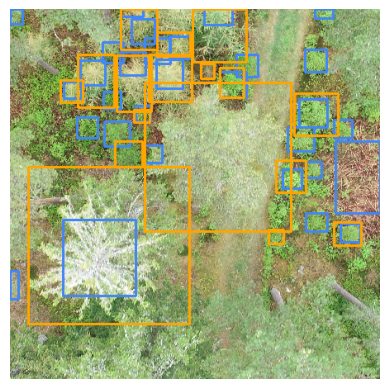

In [7]:
metadata, image, targets = box_test_data[250]
image_path = box_dataset._filename_id_to_code[int(metadata[0])]
image_path = os.path.join(box_dataset._data_dir._str, "images",image_path)

# Load the image, in this case DeepForest expects a numpy array, channels first, 0-255.
channels_first = image.permute(1, 2, 0).numpy() * 255
boxes = m.predict_image(channels_first)
ground_truth = read_file(pd.DataFrame(targets["y"].numpy(),columns=["xmin","ymin","xmax","ymax"]))
ground_truth["label"] = "Tree"
plot_results(boxes, ground_truth, image=channels_first.astype("int32"))

## Evaluation example

Every model will output predictions in a slightly different way. MillionTrees expects a dictionary of tensors, same format between predictions and ground truth.

In [8]:
y_pred = {}
y_pred["y"] = torch.tensor(boxes[["xmin", "ymin", "xmax","ymax"]].values.astype("float32"))
y_pred["labels"] = torch.tensor(boxes.label.apply(
        lambda x: m.label_dict[x]).values.astype(np.int64))
y_pred["scores"] = torch.tensor(boxes.score.values.astype("float32"))

# The eval method takes in batches, so wrap this one example in a liste
# To recover just one metric, you can grab the object directly.
box_test_data.eval([y_pred], [targets], metadata=torch.unsqueeze(metadata, dim=0))

({'accuracy': {'detection_accuracy_avg': 0.2702702581882477,
   'detection_accuracy_source_id:0': nan,
   'count_source_id:0': 0.0,
   'detection_accuracy_source_id:1': 0.2702702581882477,
   'count_source_id:1': 1.0,
   'detection_accuracy_source_id:2': nan,
   'count_source_id:2': 0.0,
   'detection_accuracy_source_id:3': nan,
   'count_source_id:3': 0.0,
   'detection_accuracy_source_id:4': nan,
   'count_source_id:4': 0.0,
   'detection_accuracy_wg': 0.2702702581882477},
  'recall': {'detection_recall_avg': 0.5882353186607361,
   'detection_recall_source_id:0': nan,
   'count_source_id:0': 0.0,
   'detection_recall_source_id:1': 0.5882353186607361,
   'count_source_id:1': 1.0,
   'detection_recall_source_id:2': nan,
   'count_source_id:2': 0.0,
   'detection_recall_source_id:3': nan,
   'count_source_id:3': 0.0,
   'detection_recall_source_id:4': nan,
   'count_source_id:4': 0.0,
   'detection_recall_wg': 0.5882353186607361},
  'detection_acc_avg_dom': nan},
 'Average detection_acc

The evaluation dictionary is broken down by 'sources' which are individual projects contributed to the MillionTrees project, listed on the 'datasets' page on the docs. For each source the dictionary gives a count of the number of images, and then the bounding box mAP accuracy score. Then it gives the average within-group 'wg' score, and the average over all groups. In this example, we just have 1 image from 1 source, so the rest of groups are nan. Let's look at the entire dataset.

For most evaluation workflows there will be some intermediary code to format the output of whatever prediction workflow to the desired eval format. It would also be nice to have a plotting function to see some examples.

In [9]:
import warnings

def format_deepforest_prediction(images, metadata, targets, m, batch_index):
    # Suppress user warnings to make more readable
    warnings.filterwarnings("ignore")
        
    images = torch.tensor(images)
    predictions = m.predict_step(images, batch_index)
    batch_results = []
    for image_metadata, pred, image_targets, image in zip(metadata,predictions, targets, images):
        basename = box_dataset._filename_id_to_code[int(image_metadata[0])]
        if pred is None:
            y_pred = {}
            y_pred["y"] = torch.zeros(4)
            y_pred["labels"] = torch.zeros(1)
            y_pred["scores"] = torch.zeros(1)
        else:
            pred.root_dir = os.path.join(box_dataset._data_dir._str, "images")
            pred["image_path"] = basename
            # Reformat to milliontrees format
            y_pred = {}
            y_pred["y"] = torch.tensor(pred[["xmin", "ymin", "xmax","ymax"]].values.astype("float32"))
            y_pred["labels"] = torch.tensor(pred.label)
            y_pred["scores"] = torch.tensor(pred.score.values.astype("float32"))
        batch_results.append(y_pred)
    
    return batch_results, predictions

# Helper function to plot evaluation results
def plot_eval_results(y_pred, pred, image_targets, image, batch_index):  
    basename = pred.image_path.unique()[0]
    ground_truth = read_file(pd.DataFrame(image_targets["y"].numpy(),columns=["xmin","ymin","xmax","ymax"]))
    ground_truth["label"] = "Tree"
    predictions_df = read_file(pred)
    predictions_df["label"] = "Tree"
    # Make image channel last
    image = image.permute(1, 2, 0).numpy()  * 255
    accuracy = box_dataset.metrics["recall"]._recall(image_targets["y"], y_pred["y"], iou_threshold=0.3)
    plot_results(predictions_df, ground_truth, image=image.astype("int32"))
    print(f"Image: {basename}, index {batch_index} with Detection Recall: {accuracy.item():.2f}")

There are 28 batches in the test loader


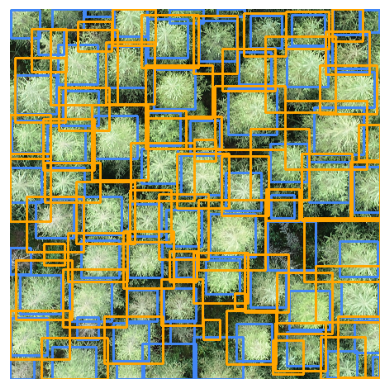

Image: B10_0056.JPG, index 0 with Detection Recall: 0.87


ValueError: x_max is less than or equal to x_min for bbox [0.402      0.88666666 0.402      0.88733333 0.        ].

In [10]:
# Get the test loader
test_loader = get_eval_loader("standard", box_test_data, batch_size=32)

# Print the length of the test loader
print("There are {} batches in the test loader".format(len(test_loader)))

# Get predictions for the full test set
all_y_pred = []
all_y_true = []

batch_index = 0
for batch in test_loader:
    metadata, images, targets  = batch
    # Get the original DeepForest, and MillionTrees formatted predictions, this is just for plotting, otherwise you just need y_pred.
    milliontrees_format, deepforest_format = format_deepforest_prediction(images, metadata, targets, m, batch_index)
    for image_metadata, y_pred, pred, image_targets, image in zip(metadata, milliontrees_format, deepforest_format, targets, images):
        # Plot every 250th image
        if batch_index % 250 == 0:
            plot_eval_results(y_pred, pred, image_targets, image, batch_index)
        # Gather all predictions and ground truth
        all_y_pred.append(y_pred)
        all_y_true.append(image_targets)
        batch_index += 1

# Evaluate
box_dataset.eval(all_y_pred, all_y_true, box_test_data.metadata_array)